# Machine Learning Project
## Gold Stock Price Prediction

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder

In [3]:
d1= pd.read_csv('FINAL_USO.csv')
print(d1.head(10))

         Date        Open        High         Low       Close   Adj Close  \
0  2011-12-15  154.740005  154.949997  151.710007  152.330002  152.330002   
1  2011-12-16  154.309998  155.369995  153.899994  155.229996  155.229996   
2  2011-12-19  155.479996  155.860001  154.360001  154.869995  154.869995   
3  2011-12-20  156.820007  157.429993  156.580002  156.979996  156.979996   
4  2011-12-21  156.979996  157.529999  156.130005  157.160004  157.160004   
5  2011-12-22  156.350006  156.800003  155.330002  156.039993  156.039993   
6  2011-12-23  156.350006  156.490005  155.820007  156.309998  156.309998   
7  2011-12-27  155.080002  155.550003  154.539993  154.910004  154.910004   
8  2011-12-28  154.050003  154.259995  150.660004  151.029999  151.029999   
9  2011-12-29  149.089996  150.720001  148.270004  150.339996  150.339996   

     Volume     SP_open     SP_high      SP_low  ...    GDX_Low  GDX_Close  \
0  21521900  123.029999  123.199997  121.989998  ...  51.570000  51.680000

In [4]:
data_types = d1.dtypes
statistics = d1.describe()
missing_values = d1.isnull().sum()
print(missing_values, statistics, data_types)

Date             0
Open             0
High             0
Low              0
Close            0
                ..
USO_High         0
USO_Low          0
USO_Close        0
USO_Adj Close    0
USO_Volume       0
Length: 81, dtype: int64               Open         High          Low        Close    Adj Close  \
count  1718.000000  1718.000000  1718.000000  1718.000000  1718.000000   
mean    127.323434   127.854237   126.777695   127.319482   127.319482   
std      17.526993    17.631189    17.396513    17.536269    17.536269   
min     100.919998   100.989998   100.230003   100.500000   100.500000   
25%     116.220001   116.540001   115.739998   116.052502   116.052502   
50%     121.915001   122.325001   121.369999   121.795002   121.795002   
75%     128.427494   129.087498   127.840001   128.470001   128.470001   
max     173.199997   174.070007   172.919998   173.610001   173.610001   

             Volume      SP_open      SP_high       SP_low     SP_close  ...  \
count  1.718000e+03

No Missing Values

In [5]:
d1['Date'] = pd.to_datetime(d1['Date'])
# Correlation matrix
correlation_matrix = d1.corr()

correlation_with_target = correlation_matrix['Close'].sort_values(ascending=False)
correlation_with_target

Close         1.000000
Adj Close     1.000000
High          0.999535
Low           0.999532
Open          0.998976
                ...   
Date         -0.686721
USDI_High    -0.720023
USDI_Open    -0.720140
USDI_Price   -0.721569
USDI_Low     -0.722078
Name: Close, Length: 81, dtype: float64

Feature Engineering

In [17]:
#Lagged Features
d1['Close_lag1'] = d1['Close'].shift(1)
d1['Close_lag2'] = d1['Close'].shift(2)

# Moving Averages
d1['Close_MA5'] = d1['Close'].rolling(window=5).mean()
d1['Close_MA10'] = d1['Close'].rolling(window=10).mean()
d1.fillna(method='bfill', inplace=True)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17128\1297771855.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d1.fillna(method='bfill', inplace=True)


In [7]:
import pandas as pd

for lag in range(1, 6):
    d1[f'Close_lag_{lag}'] = d1['Close'].shift(lag)

d1['MA_5'] = d1['Close'].rolling(window=5).mean()
d1['MA_10'] = d1['Close'].rolling(window=10).mean()

d1 = d1.dropna()

d1.head()


,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,Close_lag2,Close_MA5,Close_MA10,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,MA_5,MA_10
9,2011-12-29,149.089996,150.720001,148.270004,150.339996,150.339996,19812200,125.239998,126.250000,124.860001,...,154.910004,153.725998,154.519998,151.029999,154.910004,156.309998,156.039993,157.160004,153.725998,154.519998
10,2011-12-30,152.139999,153.750000,151.789993,151.990005,151.990005,10852700,126.019997,126.330002,125.500000,...,151.029999,152.916000,154.485999,150.339996,151.029999,154.910004,156.309998,156.039993,152.916000,154.485999
11,2012-01-03,154.759995,156.300003,154.550003,155.919998,155.919998,13385800,127.760002,128.380005,127.430000,...,150.339996,152.838000,154.554999,151.990005,150.339996,151.029999,154.910004,156.309998,152.838000,154.554999
12,2012-01-04,155.429993,157.380005,155.339996,156.710007,156.710007,11549700,127.199997,127.809998,126.709999,...,151.990005,153.198001,154.739000,155.919998,151.990005,150.339996,151.029999,154.910004,153.198001,154.739000
13,2012-01-05,155.369995,158.029999,155.250000,157.779999,157.779999,11621600,127.010002,128.229996,126.430000,...,155.919998,154.548001,154.819000,156.710007,155.919998,151.990005,150.339996,151.029999,154.548001,154.819000


Correlation Matrix

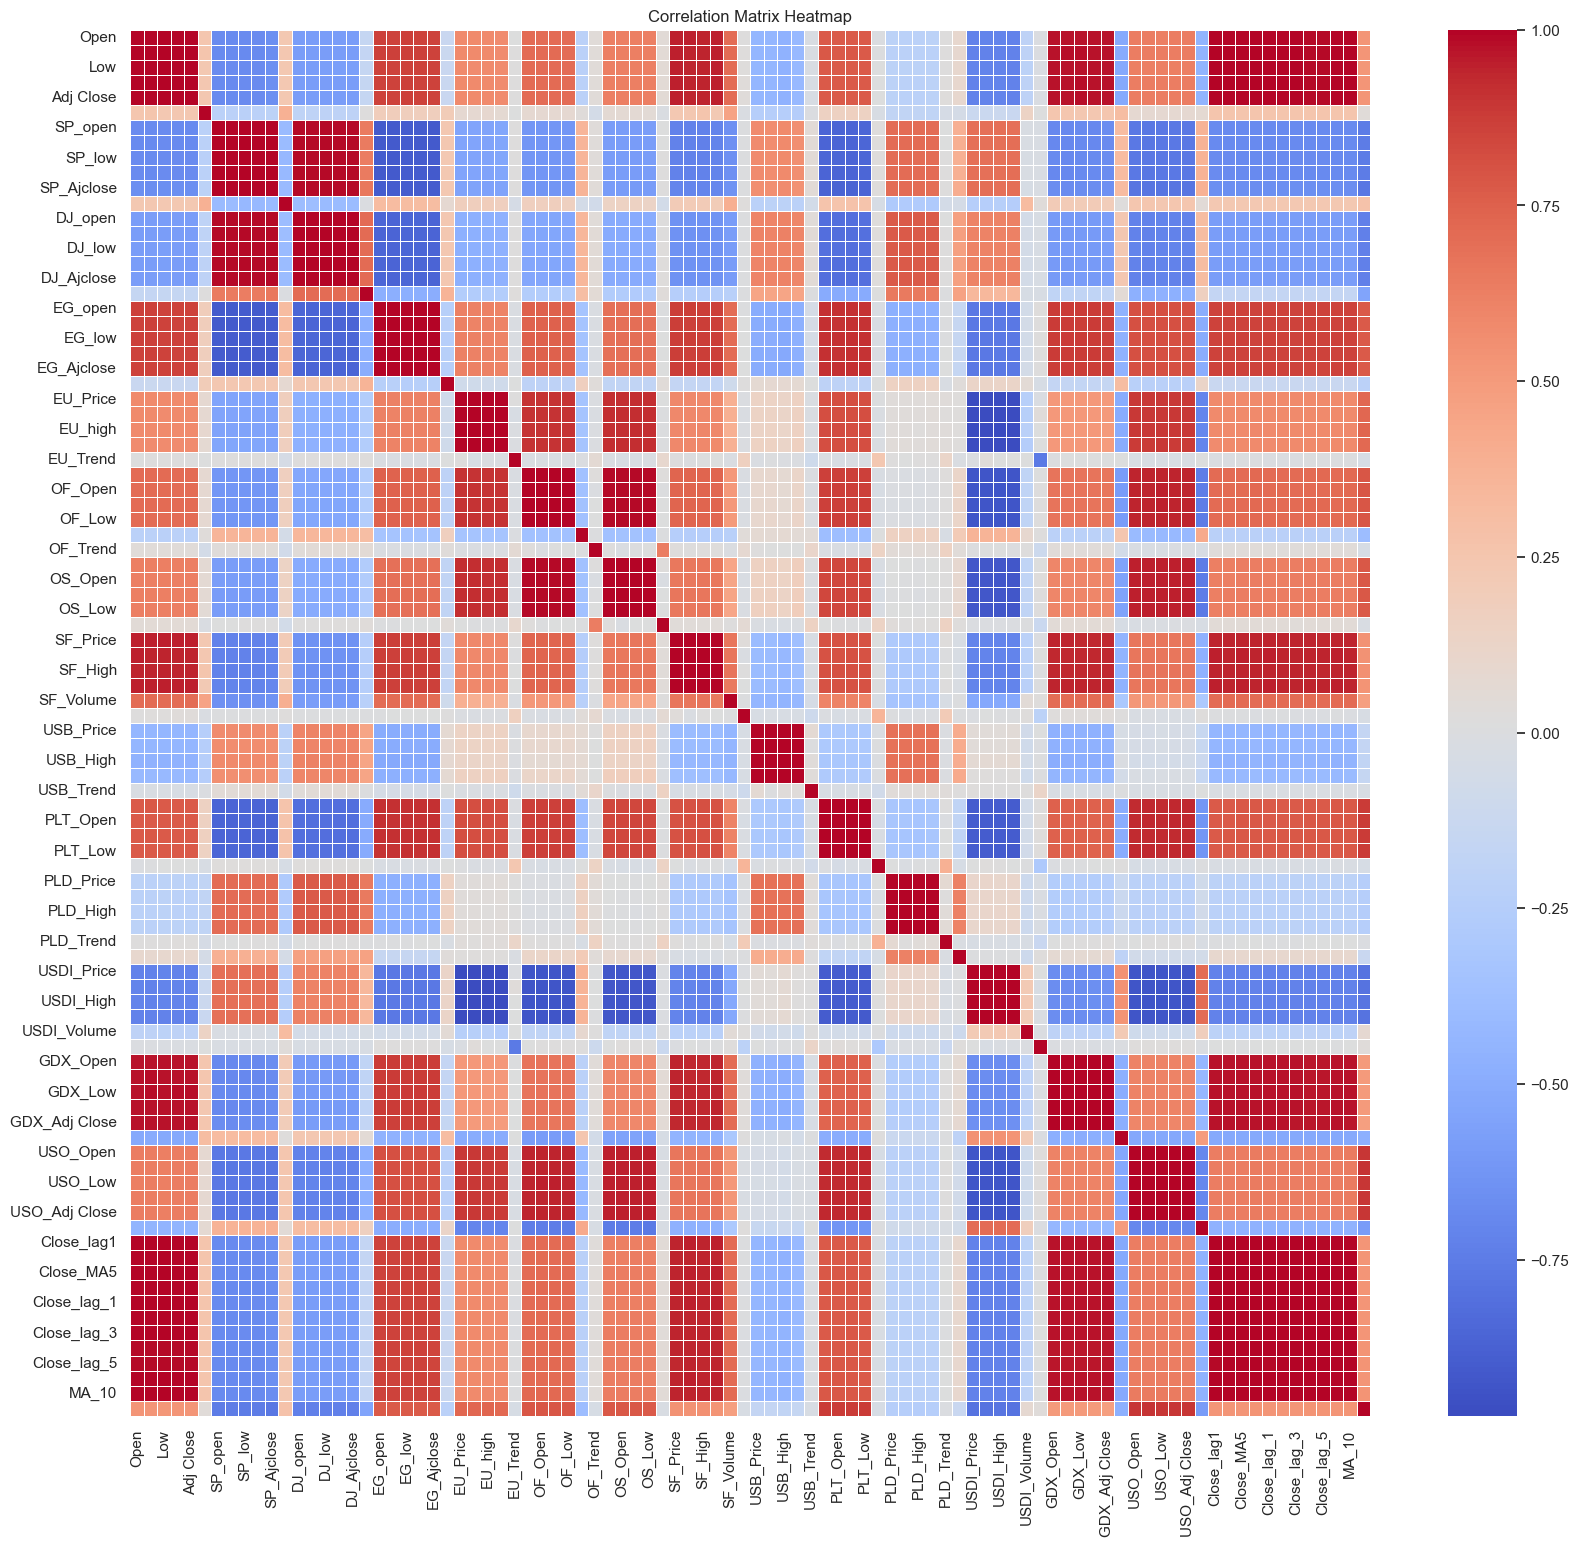

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = d1.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')

plt.show()


Data Splitting and Scaling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = d1.drop(columns=['Date', 'Close'])
y = d1['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5], X_test_scaled[:5]

(array([[ 5.08093780e-02,  2.78775894e-02,  5.36894714e-02,
          3.46414535e-02, -6.31338598e-02, -2.04126942e-01,
         -1.91051522e-01, -1.83229478e-01, -1.85312043e-01,
         -2.65202761e-01, -3.95472199e-01, -3.54657054e-01,
         -3.30724345e-01, -3.33343525e-01, -3.22514924e-01,
         -3.22514924e-01, -8.60847862e-01,  5.19176505e-01,
          5.12320021e-01,  5.06409284e-01,  4.73850791e-01,
          4.90204578e-01, -7.07817312e-01,  1.62669221e+00,
          1.63909431e+00,  1.60529986e+00,  1.66948767e+00,
         -9.77574002e-01,  1.29953915e+00,  1.30842469e+00,
          1.28681332e+00,  1.32110891e+00,  8.51940381e-03,
         -9.74716024e-01,  1.52787561e+00,  1.53364340e+00,
          1.52354586e+00,  1.54179978e+00, -9.94892342e-01,
          1.55644039e-01,  1.54139979e-01,  1.65389440e-01,
          1.99083859e-01, -1.10710608e+00,  1.04719901e+00,
          7.17515939e-01,  6.31147399e-01,  6.62898029e-01,
          6.73808239e-01,  1.00660558e+0

Initial Model Training
Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, RMSE: {rmse}, R-squared: {r2}')


MSE: 4.286974631601063e-28, RMSE: 2.0705010581018943e-14, R-squared: 1.0


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

median_uso_close = d1['USO_Close'].median()
d1['USO_Close_Binary'] = (d1['USO_Close'] > median_uso_close).astype(int)
y_binary = d1['USO_Close_Binary']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42)

logistic_regressor = LogisticRegression(max_iter=1000)
logistic_regressor.fit(X_train_bin, y_train_bin)

y_pred_bin = logistic_regressor.predict(X_test_bin)
accuracy = accuracy_score(y_test_bin, y_pred_bin)
conf_matrix = confusion_matrix(y_test_bin, y_pred_bin)
class_report = classification_report(y_test_bin, y_pred_bin)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9502923976608187
Confusion Matrix:
 [[153   8]
 [  9 172]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       161
           1       0.96      0.95      0.95       181

    accuracy                           0.95       342
   macro avg       0.95      0.95      0.95       342
weighted avg       0.95      0.95      0.95       342



c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Some useful plots to visualize information (EDA):

<Figure size 2000x1500 with 0 Axes>

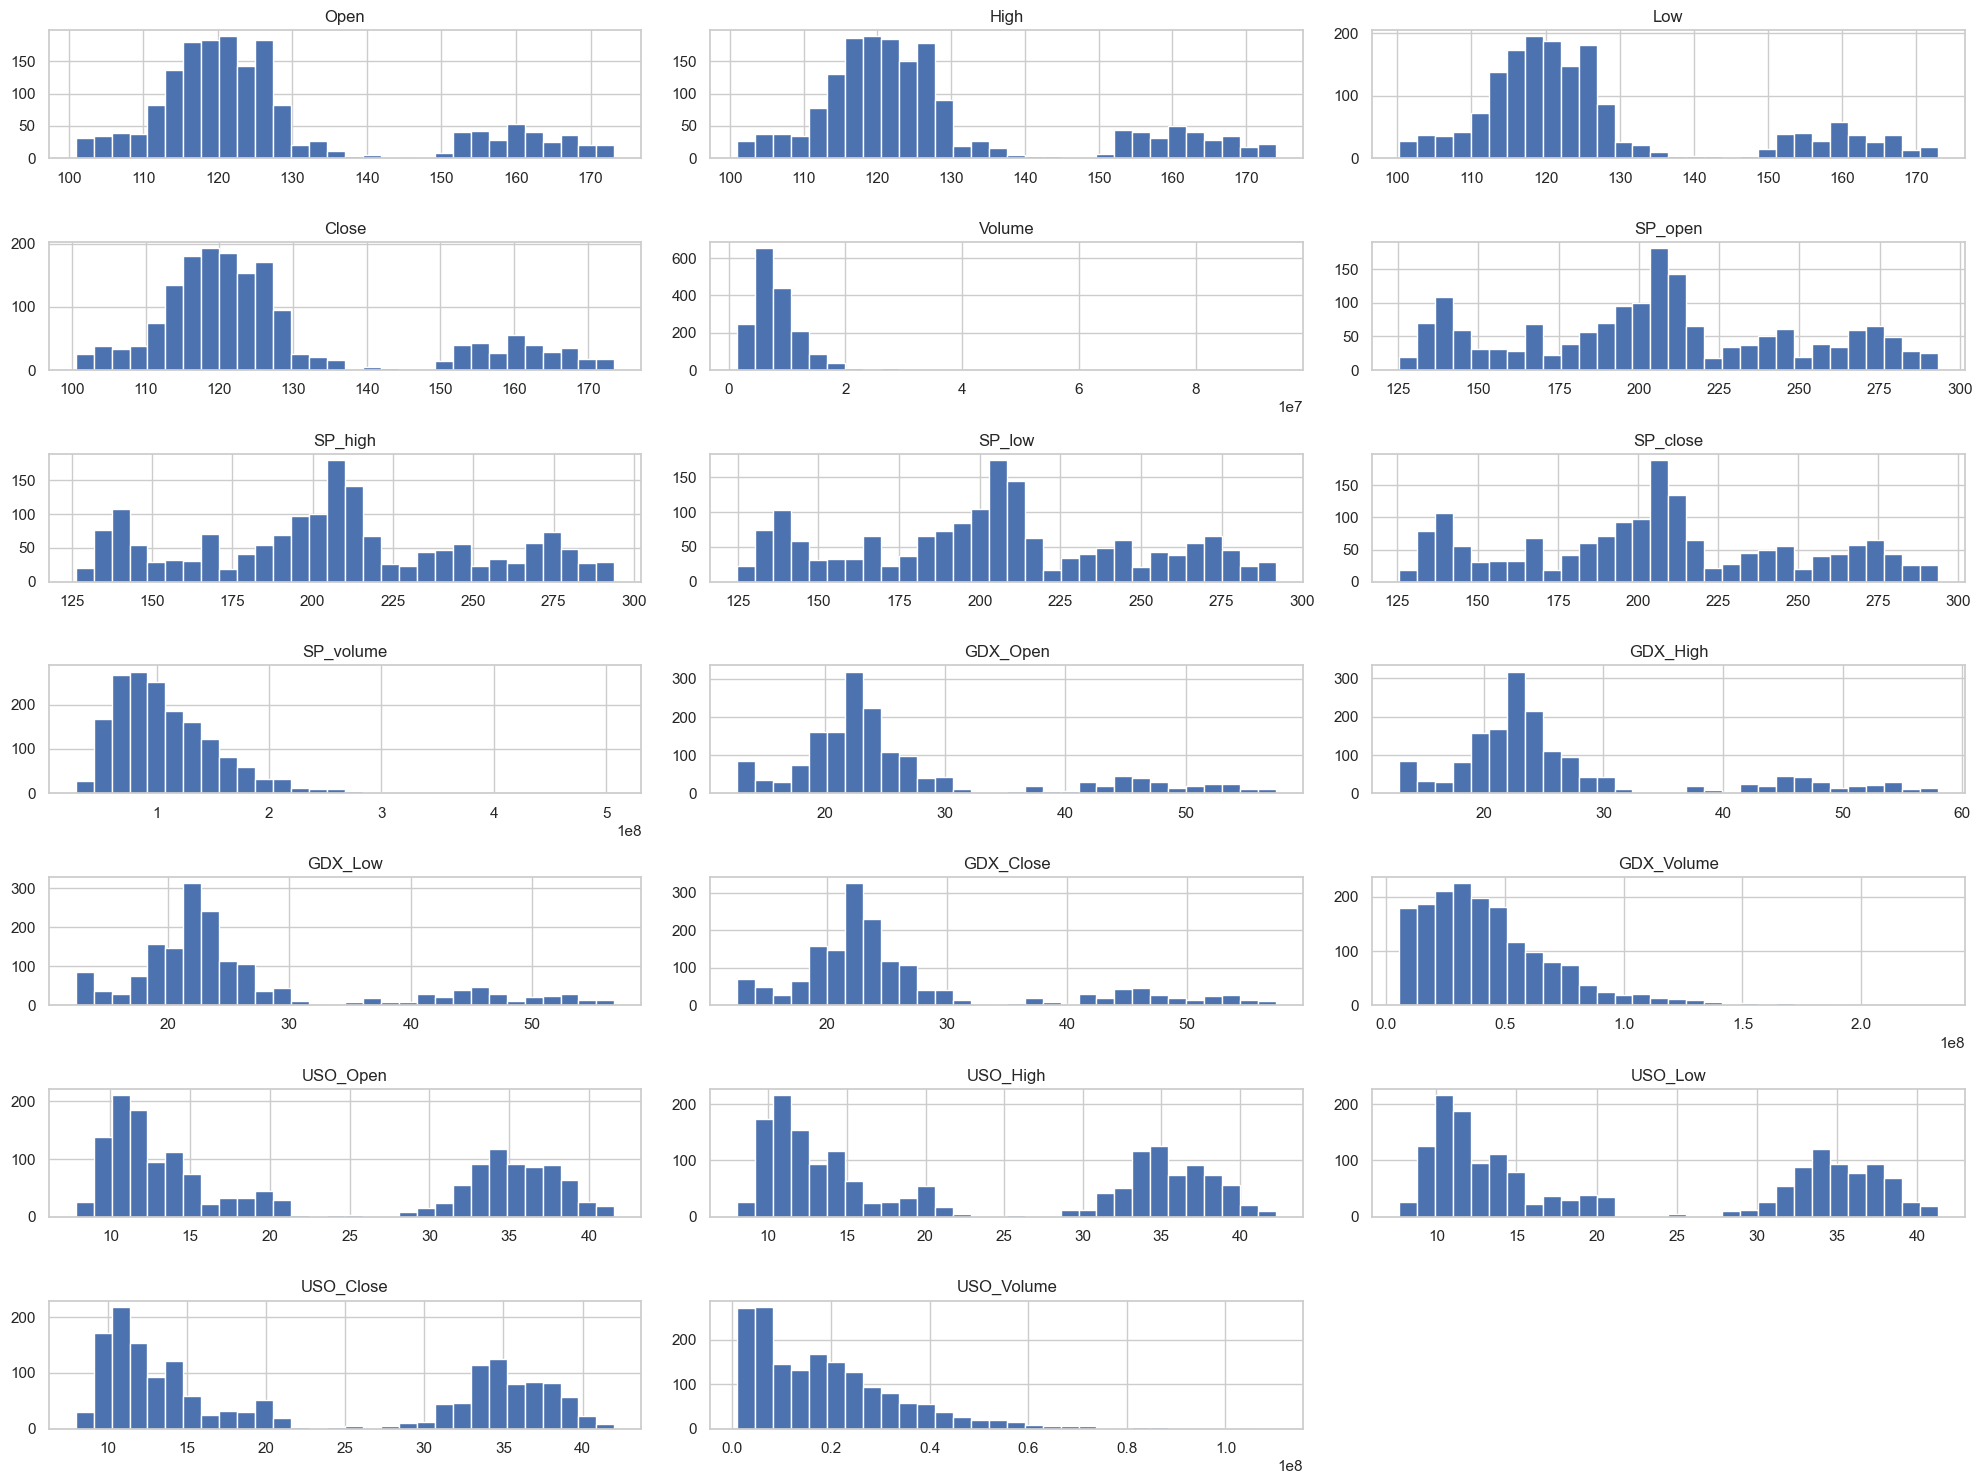

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(20, 15))

key_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close', 'SP_volume', 'GDX_Open', 'GDX_High', 'GDX_Low', 'GDX_Close', 'GDX_Volume', 'USO_Open', 'USO_High', 'USO_Low', 'USO_Close', 'USO_Volume']
d1[key_features].hist(bins=30, figsize=(20, 15), layout=(7, 3))
plt.tight_layout()
plt.show()


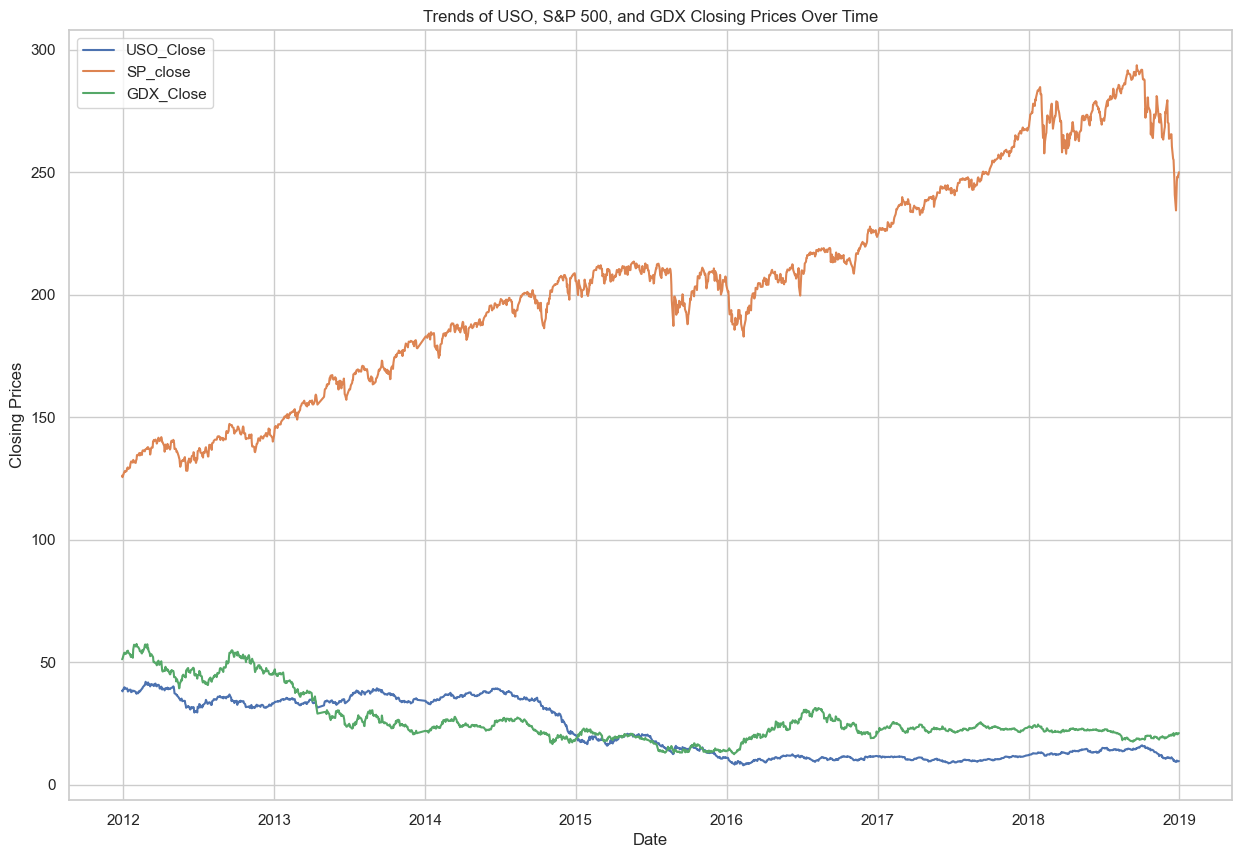

In [12]:
#Trends Over Time

d1['Date'] = pd.to_datetime(d1['Date'])

d1.set_index('Date', inplace=True)

plt.figure(figsize=(15, 10))
plt.plot(d1.index, d1['USO_Close'], label='USO_Close')
plt.plot(d1.index, d1['SP_close'], label='SP_close')
plt.plot(d1.index, d1['GDX_Close'], label='GDX_Close')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Trends of USO, S&P 500, and GDX Closing Prices Over Time')
plt.legend()
plt.show()

Relationships between variables

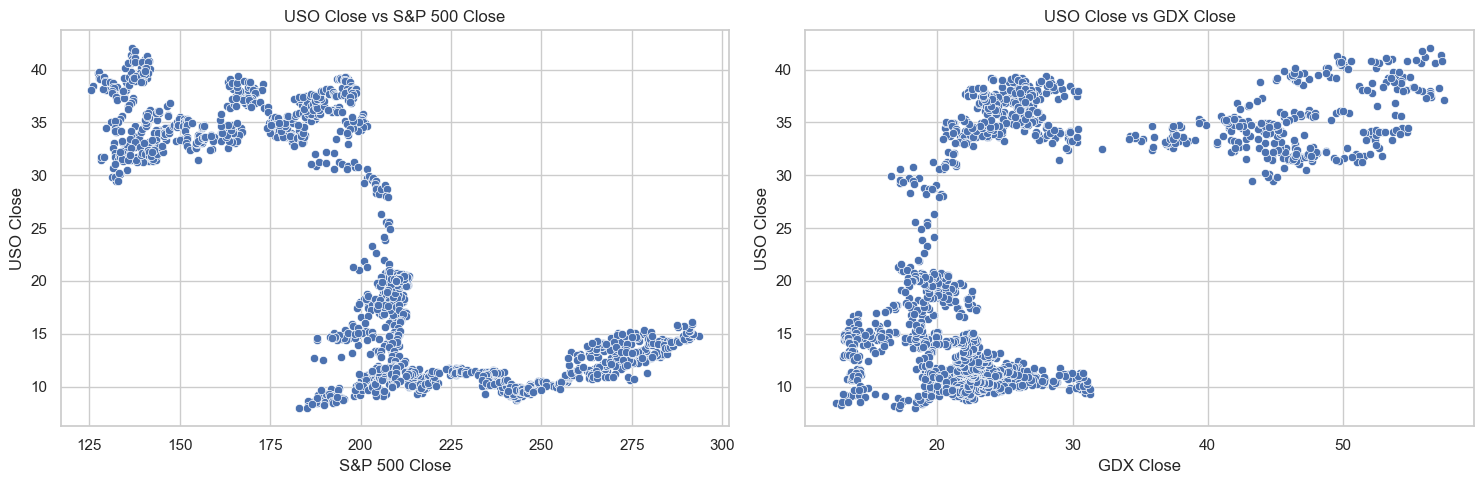

In [13]:
# Scatter plot for 'USO_Close' vs 'SP_close'
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=d1['SP_close'], y=d1['USO_Close'])
plt.xlabel('S&P 500 Close')
plt.ylabel('USO Close')
plt.title('USO Close vs S&P 500 Close')

# Scatter plot for 'USO_Close' vs 'GDX_Close'
plt.subplot(1, 2, 2)
sns.scatterplot(x=d1['GDX_Close'], y=d1['USO_Close'])
plt.xlabel('GDX Close')
plt.ylabel('USO Close')
plt.title('USO Close vs GDX Close')

plt.tight_layout()
plt.show()

PCA

Explained Variance Ratios: [0.7125237  0.12676229]


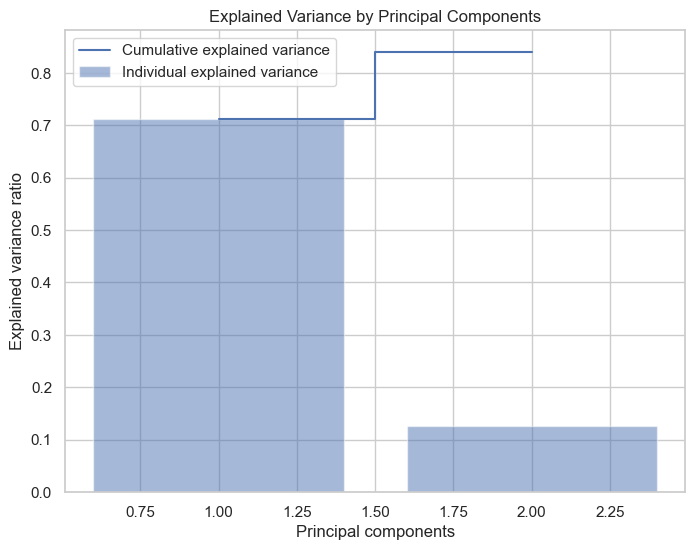

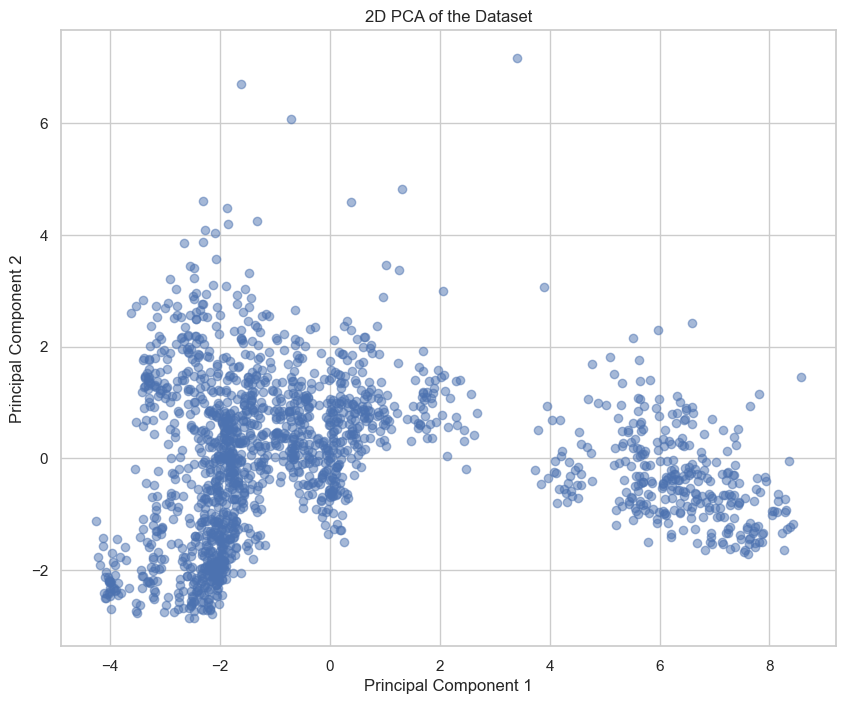

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close', 'SP_volume', 'GDX_Open', 'GDX_High', 'GDX_Low', 'GDX_Close', 'GDX_Volume']
X = d1[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Here, we choose 2 components for visualization
principal_components = pca.fit_transform(X_scaled)

principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of the Dataset')
plt.show()


Support Vector Machine
for Regression

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close', 'SP_volume', 'GDX_Open', 'GDX_High', 'GDX_Low', 'GDX_Close', 'GDX_Volume']
X = d1[features]
y = d1['USO_Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_regressor = SVR(kernel='rbf')
svm_regressor.fit(X_train, y_train)

y_pred = svm_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 84.98275786132147
R-squared: 0.36072814334896974


Random Forest

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

X = d1.drop(columns=['Close'])
y = d1['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Calculate the mean squared error
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf}")


Random Forest Mean Squared Error: 0.07021829595994045


Bagging

In [27]:
from sklearn.ensemble import BaggingRegressor

bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)

bagging_model.fit(X_train, y_train)

# Predict on the test set
y_pred_bagging = bagging_model.predict(X_test)

# Calculate the mean squared error
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f"Bagging Mean Squared Error: {mse_bagging}")


Bagging Mean Squared Error: 0.060263148567765004


Boosting

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the gradient boosting regressor
boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model
boosting_model.fit(X_train, y_train)

# Predict on the test set
y_pred_boosting = boosting_model.predict(X_test)

# Calculate the mean squared error
mse_boosting = mean_squared_error(y_test, y_pred_boosting)
print(f"Boosting Mean Squared Error: {mse_boosting}")


Boosting Mean Squared Error: 0.08823943098041474
